# Заглавие

**Автоматическое обнаружение дефектов диэлектрического слоя танталовых конденсаторов**

# Введение

Танталовый металлооксидный конденсатор обладает сложной конструкцией, включающей большое число компонентов.

![](illustrations/ta_cap_scheme.jpg)

Важным элементом конденсатора является его внутренняя часть, состоящая из пористого танталового тела с нанесенным на него диэлектриком и пропитанная катодным веществом.

![](illustrations/ta_cap_prodaction.png)

На поверхности диэлектрика возможно образование различных сколов и несовершенств. Они появляются как при производстве из-за нарушения технологического процесса, так и в результате испытаний конденсаторов при контроле качества.

![](illustrations/ETD_008.jpg)

Поскольку даже микроскопические дефекты диэлектрика могут приводить к фатальным нарушениям в работе конденсатора, то для надежной оценки его качества необходимо анализировать большое количество электронно-микроскопических изображений с высоким увеличением. По этой причине автоматическое обнаружение дефектов является актуальной задачей, которую возможно решить с помощью глубокого обучения.

Целью работы являлась мультиклассовая сегментация дефектов диэлектрического слоя танталовых анодов для получения статистически достоверной информации о структурном состоянии производимых конденсаторов.

# Импорт модулей

In [1]:
import os

import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import random

import tensorflow as tf
from tensorflow import keras
import keras.layers as layers


# Параметры

## Постоянные

In [2]:
INPUT_DIR_1 = './dataset/defects/'
TARGET_DIR_1= './dataset/segments/'
INPUT_BACK_1 = './dataset/background/'

INPUT_DIR_2 = './dataset/defects_mag_aug/'
TARGET_DIR_2= './dataset/segments_mag_aug/'

RESEARCH_DIR = './images_research/'

MODELS_DIR = './dl_models/'
HISTORY_DIR = './dl_history/'

NUM_CLASSES = 3
LABEL_SHELL = '_SHELL'
LABEL_CORE = '_CORE'

SEED = 5115
VAL_TEST_SPLIT = 0.4


Класс для хранения параметров.

In [3]:
class ModelParams:
    def __init__(self, image_size,
                 models_dir=MODELS_DIR,
                 history_dir=HISTORY_DIR,
                 name_unet_256=None,
                 history_unet_256=None):
        self.models_dir = models_dir
        self.history_dir = history_dir
        self.epochs_unet = None
        self.lr_s_unet = None
        self.fit_unet = False
        if image_size == (256, 256):
            self.image_size = image_size
            self.lr_unet = 0.0001
            self.batch_unet = 4
            self.unet = ''.join([models_dir, name_unet_256])
            self.history_unet = ''.join([history_dir, history_unet_256])
        else:
            print('Image Size Error')

    def fit_save_unet(self, model_name, history_name,
                      epochs=500, lr_s_unet=1.0):
        self.fit_unet = True
        self.unet = ''.join([self.models_dir, model_name])
        self.history_unet = ''.join([self.history_dir, history_name])
        self.epochs_unet = epochs
        self.lr_s_unet = lr_s_unet


## Изменяемые

Установим параметры моделей с помощью класса ModelParams.

In [4]:
img_pxl = 256
models_hp = ModelParams(image_size=(img_pxl, img_pxl),
                        name_unet_256='model_unet_256_lr0001_batch4_epochs500.h5',
                        history_unet_256='history_unet_256_lr0001_batch4_epochs500.csv')

#### запустить обучение U-Net ####
start_fit_unet = False
if start_fit_unet:
    unet_suf = 'lr0005_batch6_epochs500'
    models_hp.fit_save_unet('_'.join(['model_unet', str(img_pxl), unet_suf + '.h5']),
                            '_'.join(['history_unet', str(img_pxl), unet_suf + '.csv']),
                            lr_s_unet=1.0,
                            epochs=500)

#### размер входного изображения ####
IMG_SIZE = models_hp.image_size

#### параметры U-Net ####
MODEL_UNET = models_hp.unet
HISTORY_UNET = models_hp.history_unet
LR_UNET = models_hp.lr_unet
LR_S_UNET = models_hp.lr_s_unet
BATCH_UNET = models_hp.batch_unet
FIT_UNET = models_hp.fit_unet
EPOCHS_UNET = models_hp.epochs_unet


# Загрузка файлов

Проверим файлы датасета.

In [5]:
input_paths = sorted(
    [os.path.join(INPUT_DIR_1, file_name)
     for file_name in os.listdir(INPUT_DIR_1)
     if file_name.endswith('.jpg')])

background_paths = sorted(
    [os.path.join(INPUT_BACK_1, file_name)
     for file_name in os.listdir(INPUT_BACK_1)
     if file_name.endswith('.jpg')])

target_paths = sorted(
    [os.path.join(TARGET_DIR_1, file_name)
     for file_name in os.listdir(TARGET_DIR_1)
     if file_name.endswith('.png')])

print('Изображения дефектов:', len(input_paths))
print('Фоновые изображения:', len(background_paths))
print('Файлы разметки:', len(target_paths))

for i in range(5):
    print(input_paths[i], '|', background_paths[i], '|', target_paths[i])


Изображения дефектов: 344
Фоновые изображения: 614
Файлы разметки: 625
./dataset/defects/ETD_002_1.jpg | ./dataset/background/BG_ETD_002_1.jpg | ./dataset/segments/ETD_002_10_SHELL.png
./dataset/defects/ETD_002_10.jpg | ./dataset/background/BG_ETD_002_10.jpg | ./dataset/segments/ETD_002_11_SHELL.png
./dataset/defects/ETD_002_11.jpg | ./dataset/background/BG_ETD_002_11.jpg | ./dataset/segments/ETD_002_1_CORE.png
./dataset/defects/ETD_002_2.jpg | ./dataset/background/BG_ETD_002_12.jpg | ./dataset/segments/ETD_002_1_SHELL.png
./dataset/defects/ETD_002_3.jpg | ./dataset/background/BG_ETD_002_13.jpg | ./dataset/segments/ETD_002_2_CORE.png


Создадим массив изображений.

In [6]:
def files_to_arrays(input_dir, target_dir=False,
                    image_size=IMG_SIZE, random_seed=None):

    input_img_paths = [os.path.join(input_dir, file_name)
                       for file_name in os.listdir(input_dir)
                       if file_name.endswith('.jpg')]
    random.Random(random_seed).shuffle(input_img_paths)

    X_list = []
    for i in input_img_paths:
        image = Image.open(i).resize(size=image_size)
        image = np.array(image)
        image = image / image.max()
        # в результате обработки в графическом редакторе
        # появляются дополнительные каналы (1, 2)
        # значения в которых равны нулевому каналу
        if len(image.shape) > 2:
            image = image[..., 0]
        X_list.append(image)
    X = np.array(X_list).astype('float64')
    X = np.expand_dims(X, 3)

    if target_dir:
        target_img_paths = [os.path.join(target_dir, file_name)
                            for file_name in os.listdir(target_dir)
                            if file_name.endswith('.png')]

        y_list = []
        for i in input_img_paths:
            input_name = i.replace(input_dir, '').replace('.jpg', '')
            target_array = np.zeros(IMG_SIZE + (2,))
            target_array = np.insert(target_array, 0, np.ones(IMG_SIZE), axis=2)

            for j in target_img_paths:
                target_name = j.replace(target_dir, '').replace('.png', '')
                if target_name.endswith(LABEL_SHELL) and (target_name.replace(LABEL_SHELL, '') == input_name):
                    segment = Image.open(j).resize(size=image_size)
                    segment = np.array(segment)
                    segment = segment / segment.max()
                    target_array[:,:,1] += segment
                elif target_name.endswith(LABEL_CORE) and (target_name.replace(LABEL_CORE, '') == input_name):
                    segment = Image.open(j).resize(size=image_size)
                    segment = np.array(segment)
                    segment = segment / segment.max()
                    target_array[:,:,2] += segment

            mask_background = np.logical_and(np.logical_or(target_array[:,:,1], target_array[:,:,2]),
                                             target_array[:,:,0])
            target_array[:,:,0] *= np.logical_not(mask_background)

            mask_metal = np.logical_and(target_array[:,:,1], target_array[:,:,2])
            target_array[:,:,2] *= np.logical_not(mask_metal)

            target_array = np.ceil(target_array).astype('uint8')
            y_list.append(target_array)
        y = np.array(y_list)

    else:
        y_list = []
        for _ in input_img_paths:
            target_array = np.zeros(IMG_SIZE + (2,))
            target_array = np.insert(target_array, 0, np.ones(IMG_SIZE), axis=2)
            target_array = target_array.astype('uint8')
            y_list.append(target_array)
        y = np.array(y_list)

    return X, y


In [7]:
def arrays_info(X, y):

    print('Размер массива изображений:', X.shape)
    print('Min X =', X.min(), '|', 'Max X =', X.max())
    print('Размер массива разметки:', y.shape)
    print('Min y =', y.min(), '|', 'Max y =', y.max())
    print('Уникальные значения y:', np.unique(y))
    print('Количество попарных пересечений между классами разметки:',
          np.logical_and(y[..., 0], y[..., 1]).sum() +
          np.logical_and(y[..., 0], y[..., 2]).sum() +
          np.logical_and(y[..., 1], y[..., 2]).sum())


Загрузим файлы в массив и перемешаем их.

In [8]:
X_1, y_1 = files_to_arrays(INPUT_DIR_1, TARGET_DIR_1, random_seed=SEED)
X_back_1, y_back_1 = files_to_arrays(INPUT_BACK_1, random_seed=SEED)

X = np.concatenate([X_1, X_back_1], axis=0)
y = np.concatenate([y_1, y_back_1], axis=0)

np.random.seed(SEED + 1)
array_ind = np.random.choice(range(X.shape[0]), X.shape[0], replace=False)

X = X[array_ind]
y = y[array_ind]

arrays_info(X, y)


Размер массива изображений: (958, 256, 256, 1)
Min X = 0.0 | Max X = 1.0
Размер массива разметки: (958, 256, 256, 3)
Min y = 0 | Max y = 1
Уникальные значения y: [0 1]
Количество попарных пересечений между классами разметки: 0


Разделим полученный массив на тренировочную и тестовую выборки.

In [9]:
val_test_size = int(X.shape[0] * VAL_TEST_SPLIT)

X_train = X[:-val_test_size]
y_train = y[:-val_test_size]

X_val_test = X[-val_test_size:]
y_val_test = y[-val_test_size:]

X_val, X_test = X_val_test[:X_val_test.shape[0] // 2], \
                X_val_test[X_val_test.shape[0] // 2:]
y_val, y_test = y_val_test[:y_val_test.shape[0] // 2], \
                y_val_test[y_val_test.shape[0] // 2:]

print('Количество изображений в тренировочном массиве:', X_train.shape[0])
print('Количество изображений в валидационном массиве:', X_val.shape[0])
print('Количество изображений в тестовом массиве:', X_test.shape[0])


Количество изображений в тренировочном массиве: 575
Количество изображений в валидационном массиве: 191
Количество изображений в тестовом массиве: 192


# Аугментация

Добавим повороты изображений.

In [10]:
def rotation_and_crop(X_train, y_train, rotate_angle, crop_size):

    X_list = []
    y_list = []

    for i in range(X_train.shape[0]):

        X_img = Image.fromarray(X_train[i, :, :, 0])
        X_rcz = X_img.rotate(angle=rotate_angle)\
                 .crop(box=(crop_size,
                            crop_size,
                            IMG_SIZE[0] - crop_size,
                            IMG_SIZE[1] - crop_size))\
                 .resize(size=IMG_SIZE)

        X_rcz_array = np.array(X_rcz)
        X_rcz_array = np.where(X_rcz_array < 0, 0, X_rcz_array)
        X_rcz_array = np.where(X_rcz_array > 1, 1, X_rcz_array)
        X_rcz_array_dims = np.expand_dims(X_rcz_array, (0, 3))

        X_list.append(X_rcz_array_dims)

        y_img = Image.fromarray(y_train[i, :, :, :])
        y_rcz = y_img.rotate(angle=rotate_angle)\
                 .crop(box=(crop_size,
                            crop_size,
                            IMG_SIZE[0] - crop_size,
                            IMG_SIZE[1] - crop_size))\
                 .resize(size=IMG_SIZE)

        y_rcz_array = np.array(y_rcz)
        y_rcz_array = np.where(y_rcz_array < 0, 0, y_rcz_array)
        y_rcz_array = np.where(y_rcz_array > 1, 1, y_rcz_array)
        y_rcz_array_dims = np.expand_dims(y_rcz_array, 0)

        y_list.append(y_rcz_array_dims)

    X_aug = np.concatenate(X_list, axis=0)
    y_aug = np.concatenate(y_list, axis=0)

    return X_aug, y_aug


Создадим массив с поворотами изображений, размер которого равен размеру тренировочного массива.

In [11]:
X_rot_90, y_rot_90 = rotation_and_crop(X_train, y_train, 90, 0)
X_rot_180, y_rot_180 = rotation_and_crop(X_train, y_train, 180, 0)
X_rot_270, y_rot_270 = rotation_and_crop(X_train, y_train, 270, 0)

X_rot = np.concatenate([X_rot_90, X_rot_180, X_rot_270], axis=0)
y_rot = np.concatenate([y_rot_90, y_rot_180, y_rot_270], axis=0)

np.random.seed(SEED + 2)
rot_ind = np.random.choice(range(X_rot.shape[0]), X_train.shape[0], replace=False)

X_rot = X_rot[rot_ind]
y_rot = y_rot[rot_ind]


Добавим изображения, размер анализируемой (захватываемой рамкой окна) площади образца в которых, отличается от стандартного.

In [12]:
X_mag, y_mag = files_to_arrays(INPUT_DIR_2, TARGET_DIR_2, random_seed=SEED)
arrays_info(X_mag, y_mag)


Размер массива изображений: (175, 256, 256, 1)
Min X = 0.0 | Max X = 1.0
Размер массива разметки: (175, 256, 256, 3)
Min y = 0 | Max y = 1
Уникальные значения y: [0 1]
Количество попарных пересечений между классами разметки: 0


Соединим исходный тренировочный и измененный массивы, после чего перемешаем их.

In [13]:
X_train_aug = np.concatenate([X_train, X_rot, X_mag], axis=0)
y_train_aug = np.concatenate([y_train, y_rot, y_mag], axis=0)

np.random.seed(SEED + 3)
random_ind = np.random.choice(range(X_train_aug.shape[0]), X_train_aug.shape[0], replace=False)

X_train_aug = X_train_aug[random_ind]
y_train_aug = y_train_aug[random_ind]

arrays_info(X_train_aug, y_train_aug)


Размер массива изображений: (1325, 256, 256, 1)
Min X = 0.0 | Max X = 1.0
Размер массива разметки: (1325, 256, 256, 3)
Min y = 0 | Max y = 1
Уникальные значения y: [0 1]
Количество попарных пересечений между классами разметки: 0


Проверим соответствие массивов изображений и разметки.

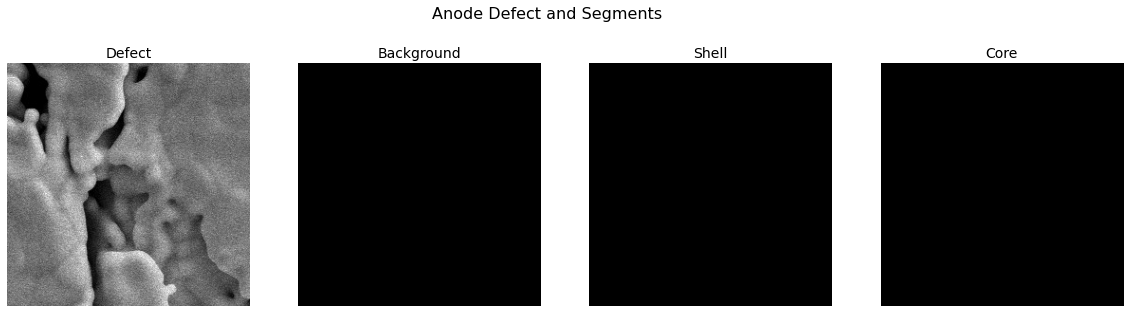

Defect Area on Segments (pixels):
Background: 65536
Shell: 0
Core: 0


In [14]:
np.random.seed(None)
idx = np.random.randint(X_train_aug.shape[0])

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))

ax[0].imshow(X_train_aug[idx], cmap='gray')
ax[0].set_title('Defect', size=14)
ax[0].axis('off')

for i, j in zip(range(1, 4), ['Background', 'Shell', 'Core']):
    ax[i].imshow(y_train_aug[idx, :, :, i - 1], cmap='gray')
    ax[i].set_title(j, size=14)
    ax[i].axis('off')

fig.suptitle('Anode Defect and Segments', size=16, y=0.75)
plt.show()

print('Defect Area on Segments (pixels):')
for j1, j2 in zip(['Background:', 'Shell:', 'Core:'], range(3)):
    print(j1, y_train_aug[idx,:,:,j2].sum())


# Подготовка модели

## U-Net

Схематичное представление архитектуры U-Net.

![](illustrations/dl_u_net.jpg)

In [15]:
def get_unet(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))
    # Down 1
    conv1 = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    conv1 = layers.Dropout(0.2)(conv1)
    conv1 = layers.Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    # Down 2
    conv2 = layers.Conv2D(64, (3, 3), padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    conv2 = layers.Dropout(0.2)(conv2)
    conv2 = layers.Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    # Down 3
    conv3 = layers.Conv2D(128, (3, 3), padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    conv3 = layers.Dropout(0.2)(conv3)
    conv3 = layers.Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    # Down 4
    conv4 = layers.Conv2D(256, (3, 3), padding='same')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    conv4 = layers.Dropout(0.2)(conv4)
    conv4 = layers.Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    # Bottleneck
    conv5 = layers.Conv2D(512, (3, 3), padding='same')(pool4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)
    conv5 = layers.Dropout(0.2)(conv5)
    conv5 = layers.Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)
    # Up 1
    up6 = layers.concatenate([layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = layers.Conv2D(256, (3, 3), padding='same')(up6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)
    conv6 = layers.Dropout(0.2)(conv6)
    conv6 = layers.Conv2D(256, (3, 3), padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)
    # Up 2
    up7 = layers.concatenate([layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = layers.Conv2D(128, (3, 3), padding='same')(up7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)
    conv7 = layers.Dropout(0.2)(conv7)
    conv7 = layers.Conv2D(128, (3, 3), padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)
    # Up 3
    up8 = layers.concatenate([layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = layers.Conv2D(64, (3, 3), padding='same')(up8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Activation('relu')(conv8)
    conv8 = layers.Dropout(0.2)(conv8)
    conv8 = layers.Conv2D(64, (3, 3), padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Activation('relu')(conv8)
    # Up 4
    up9 = layers.concatenate([layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = layers.Conv2D(32, (3, 3), padding='same')(up9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Activation('relu')(conv9)
    conv9 = layers.Dropout(0.2)(conv9)
    conv9 = layers.Conv2D(32, (3, 3), padding='same')(conv9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Activation('relu')(conv9)
    # Output
    conv10 = layers.Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(conv9)

    model_unet = keras.Model(inputs=[inputs], outputs=[conv10])

    return model_unet

keras.backend.clear_session()

model_unet = get_unet(img_size=IMG_SIZE, num_classes=NUM_CLASSES)
model_unet.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

 rmalization)                                                                                     
                                                                                                  
 activation_7 (Activation)      (None, 32, 32, 256)  0           ['batch_normalization_7[0][0]']  
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 16, 16, 256)  0          ['activation_7[0][0]']           
                                                                                                  
 conv2d_8 (Conv2D)              (None, 16, 16, 512)  1180160     ['max_pooling2d_3[0][0]']        
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 16, 16, 512)  2048       ['conv2d_8[0][0]']               
 rmalization)                                                                                     
          

                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 64  36928       ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_15 (BatchN  (None, 128, 128, 64  256        ['conv2d_15[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_15 (Activation)     (None, 128, 128, 64  0           ['batch_normalization_15[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_tr

# Обучение модели

## U-Net

In [16]:
keras.backend.clear_session()
if FIT_UNET:
    keras.backend.clear_session()
    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * LR_S_UNET

    model_unet.compile(optimizer=keras.optimizers.Adam(learning_rate=LR_UNET),
                       loss="categorical_crossentropy",
                       metrics=["accuracy"]) #[tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)]

    callbacks_unet = [keras.callbacks.ModelCheckpoint(MODEL_UNET, save_best_only=True),
                      tf.keras.callbacks.LearningRateScheduler(scheduler)]

    history_unet = model_unet.fit(X_train_aug, y_train_aug,
                                  callbacks=callbacks_unet,
                                  epochs=EPOCHS_UNET,
                                  batch_size=BATCH_UNET,
                                  validation_data=(X_val, y_val),
                                  verbose=1,
                                  shuffle=True)

    hist_unet_df = pd.DataFrame(history_unet.history)
    hist_unet_df.to_csv(HISTORY_UNET, index=False)


# История обучения

In [17]:
def show_history(hist_df, name,
                 image_size=None,
                 batch_size=None, lr=None):

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))

    ax[0].plot(hist_df['val_accuracy'], 'violet', label='val_accuracy')
    ax[0].plot(hist_df['accuracy'], 'g', label='accuracy')
    ax[0].set_title(' '.join(['Image Size:', str(image_size), ' | ',
                              'Batch Size:', str(batch_size), ' | ',
                              'Learning Rate:', str(lr), '---->',
                              str(hist_df.loc[len(hist_df) - 1, 'lr'].round(5))
                              if 'lr' in hist_df.columns else str(lr)]),
                    size=14)
    ax[0].set_ylabel('Metrics', size=14)
    ax[0].legend(fontsize=12)

    ax[1].plot(hist_df['val_loss'], 'r', label='val_loss')
    ax[1].plot(hist_df['loss'], 'b', label='loss')
    ax[1].set_xlabel('Epochs', size=14)
    ax[1].set_ylabel('Loss', size=14)
    ax[1].set_yscale('log')
    ax[1].legend(fontsize=12)

    plt.suptitle(' - '.join(['Train History', name]), size=16)
    plt.show()


## U-Net

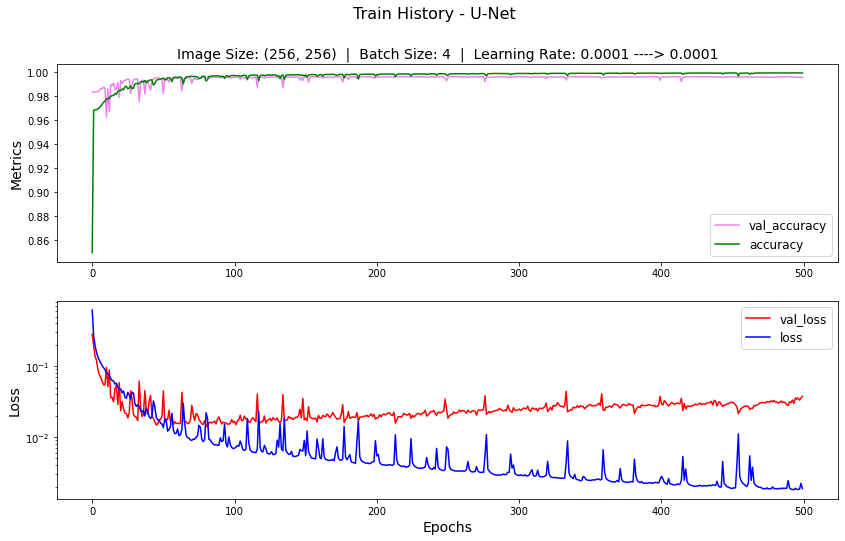

In [18]:
hist_unet_df = pd.read_csv(HISTORY_UNET)
show_history(hist_unet_df, 'U-Net',
             image_size=IMG_SIZE,
             batch_size=BATCH_UNET, lr=LR_UNET)


# Качество предсказания

## Метрики

In [19]:
best_unet = keras.models.load_model(MODEL_UNET)

test_results_unet = best_unet.evaluate(X_test, y_test, batch_size=BATCH_UNET, verbose=0)
print('U-Net Model')
print('X_test - Accuracy:', round(test_results_unet[1], 5)) #'Mean IoU'
print('X_test - Loss:', round(test_results_unet[0], 5))

y_prob_unet = best_unet.predict(X_test, batch_size=BATCH_UNET, verbose=0)


U-Net Model
X_test - Accuracy: 0.99482
X_test - Loss: 0.01888


## Визуализация

In [20]:
def show_proba_values(y_prob, name):

    print(' '.join([name, 'Model']))
    for i1, i2 in zip(['Максимальные значения по каналам:',
                       'Медианные значения по каналам:',
                       'Минимальные значения по каналам:'], range(3)):
        if i2 > 0:
            print()
        print(i1, end=' ')
        for j in range(3):
            if i2 == 0:
                print(np.max(y_prob[..., j]), end=' ')
            elif i2 == 1:
                print(np.median(y_prob[..., j]), end=' ')
            elif i2 == 2:
                print(np.min(y_prob[..., j]), end=' ')


In [21]:
show_proba_values(y_prob_unet, 'U-Net')


U-Net Model
Максимальные значения по каналам: 1.0 0.9993967 0.9969819 
Медианные значения по каналам: 0.9999424 3.12977e-05 1.51251525e-05 
Минимальные значения по каналам: 0.00018754581 1.1319595e-09 9.300307e-11 

Функция для определения канала с максимальной вероятностью.

In [22]:
def proba_to_argmax(y_prob):

    y_zeros = np.zeros(y_prob.shape)
    y_argmax = np.argmax(y_prob, axis=3)

    for chanel in range(y_prob.shape[-1]):
        y_zeros[..., chanel] += np.where(y_argmax == chanel, 1, 0)

    y_proba_to_argmax = y_zeros.astype('uint8')

    return y_proba_to_argmax


In [23]:
y_pred_unet = proba_to_argmax(y_prob_unet)


Определим величину метрики MeanIoU по каждому из трех каналов в отдельности.

In [24]:
print("MeanIoU")
print("U-Net")
for ch, n_ch in zip(["Background", "Shell", "Core"],
                    [0, 1, 2]):

    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state(y_test[..., n_ch], y_pred_unet[..., n_ch])
    print(f"{ch}: {m.result().numpy():.3f}")


MeanIoU
U-Net
Background: 0.828
Shell: 0.796
Core: 0.788


Посмотрим как модель определяет дефекты.

In [25]:
def show_segments_and_prediction(X, y_true, y_pred,
                                 name=None, random_seed=None):

    np.random.seed(random_seed)
    idx_test = np.random.randint(X.shape[0])

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,12))

    for i1, i2, i3 in zip(range(2), [y_true, y_pred], ['Segment', 'Prediction']):
        for j1, j2 in zip(range(3), ['Background', 'Shell', 'Core']):
            ax[i1, j1].imshow(i2[idx_test,:,:,j1], cmap='gray')
            ax[i1, j1].set_title(' '.join([i3, j2]), size=14)
            ax[i1, j1].axis('off')
    fig.suptitle(' - '.join(["Anode Defect Prediction", name]), size=16, y=0.95)
    plt.show()

    plt.imshow(X[idx_test], cmap='gray')
    plt.axis('off')
    plt.show()

    for i1, i2 in zip(['Defect Area on Segments (pixels):',
                       'Defect Area on Prediction (pixels):'],
                      [y_true, y_pred]):
        print(i1)
        for j1, j2 in zip(['Background:', 'Shell:', 'Core:'], range(3)):
            print(j1, i2[idx_test,:,:,j2].sum())
        print()


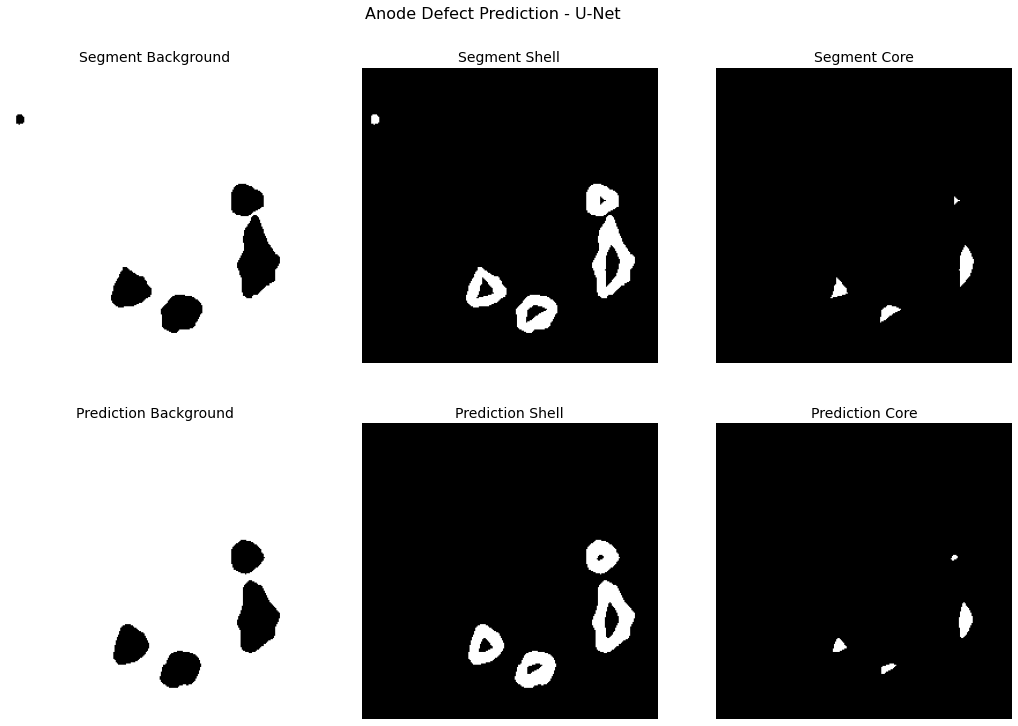

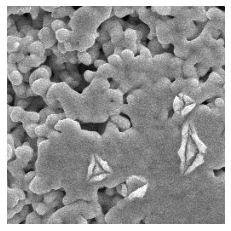

Defect Area on Segments (pixels):
Background: 61540
Shell: 3431
Core: 565

Defect Area on Prediction (pixels):
Background: 61743
Shell: 3371
Core: 422



In [88]:
show_segments_and_prediction(X_test, y_test, y_pred_unet, 'U-Net')


# Использование модели

Исследуем как происходит сегментация изображения с помощью разных моделей и разного размера скользящего окна.

In [27]:
class ResearchAnode:

    def __init__(self, dl_model, research_dir=RESEARCH_DIR,
                 image_size=(1536, 1094), down_crop=70,
                 window_size=IMG_SIZE, nch_to3=False):

        self.dl_model = dl_model
        self.research_dir = research_dir
        self.image_size = image_size
        self.down_crop = down_crop
        self.window_size = window_size
        self.nch_to3 = nch_to3
        self.file_path = None
        self.research_image = None
        self.result_image = None
        self.shell_pixels = None
        self.shell_density = None
        self.core_pixels = None
        self.core_density = None
        self.window_step = None

    def segmentation(self, file_name, window_step=False, sum_argmax=False,
                     batch_size=1, verbose=0):

        if not window_step:
            window_step = self.window_size[0]
        elif (window_step > self.window_size[0]) or (window_step <= 0):
            window_step = self.window_size[0]

        self.window_step = window_step
        self.file_path = ''.join([RESEARCH_DIR, file_name])

        research_image = Image.open(self.file_path).resize(size=self.image_size)
        research_image = np.array(research_image)
        research_image = research_image / research_image.max()
        # в результате обработки в графическом редакторе
        # появляются дополнительные каналы (1, 2)
        # значения в которых равны нулевому каналу
        if len(research_image.shape) > 2:
            research_image = research_image[..., 0]
        # обрезаем информацию об увеличении
        research_image = research_image[:research_image.shape[0] - self.down_crop]

        # увеличиваем изображение, чтобы скользящее окно умещалось целое количество раз
        if (research_image.shape[0] - self.window_size[0]) % window_step != 0:
            add_axis0 = window_step - (research_image.shape[0] - self.window_size[0]) % window_step
        else:
            add_axis0 = 0

        if (research_image.shape[1] - self.window_size[1]) % window_step != 0:
            add_axis1 = window_step - (research_image.shape[1] - self.window_size[1]) % window_step
        else:
            add_axis1 = 0

        image_wide = np.insert(research_image, research_image.shape[0],
                               np.zeros((add_axis0, research_image.shape[1])),
                               axis=0)
        image_wide = np.insert(image_wide, image_wide.shape[1],
                               np.zeros((add_axis1, image_wide.shape[0])),
                               axis=1)

        new_image = np.zeros((1,) + image_wide.shape + (NUM_CLASSES,))
        image_wide_dims = np.expand_dims(image_wide, (0,3))

        if self.nch_to3:
            image_wide_dims = np.concatenate([image_wide_dims, image_wide_dims, image_wide_dims], axis=3)

        # превращаем изображение в массив для предсказания
        image_slices = []
        i = 0
        while i * window_step + self.window_size[0] <= image_wide.shape[0]:
            j = 0
            while j * window_step + self.window_size[1] <= image_wide.shape[1]:
                image_slices.append(
                          image_wide_dims[:,
                          i * window_step:i * window_step + self.window_size[0],
                          j * window_step:j * window_step + self.window_size[1],
                          :])
                j += 1
            i += 1

        image_slices_array = np.concatenate(image_slices, axis=0)
        predict_slices = self.dl_model.predict(image_slices_array, batch_size=batch_size, verbose=verbose)

        # перед суммированием интенсивностей сегментов найти максимальный
        # остальные приравнять к нулю
        if sum_argmax:
            predict_slices = proba_to_argmax(predict_slices)

        # разворачиваем массив в изображение сегментов
        i = 0
        slice_num = 0
        while i * window_step + self.window_size[0] <= image_wide.shape[0]:
            j = 0
            while j * window_step + self.window_size[1] <= image_wide.shape[1]:
                new_image[:,
                          i * window_step:i * window_step + self.window_size[0],
                          j * window_step:j * window_step + self.window_size[1],
                          :] += predict_slices[slice_num]
                slice_num += 1
                j += 1
            i += 1

        research_predict = proba_to_argmax(new_image)
        result = research_predict[0, ...]
        result = result[:research_image.shape[0], :research_image.shape[1]]

        self.research_image = research_image
        self.result_image = np.concatenate([np.expand_dims(self.research_image, 2),
                                            result[..., 1:]], axis=2)

        self.shell_pixels = self.result_image[..., 1].sum().astype('int')
        self.shell_density = round(self.result_image[..., 1].sum() /
                             (self.result_image.shape[0] * self.result_image.shape[1]), 5)
        self.core_pixels = self.result_image[..., 2].sum().astype('int')
        self.core_density = round(self.result_image[..., 2].sum() /
                            (self.result_image.shape[0] * self.result_image.shape[1]), 5)

    def show_result(self):

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,10))

        ax[0].imshow(self.research_image, cmap='gray')
        ax[0].set_title('Research Image', size=14)
        ax[0].axis('off')

        ax[1].imshow(self.result_image)
        ax[1].set_title('Segmentation', size=14)
        ax[1].axis('off')
        plt.show()

        print('FILE name:', self.file_path.replace(self.research_dir, ''))
        print('IMAGE size:', self.result_image.shape[0:2])
        print('SHELL - pixels: Number =', self.shell_pixels,
                          ' |  Density =', self.shell_density)
        print('CORE - pixels: Number =', self.core_pixels,
                          ' |  Density =', self.core_density)


## Различная степень пересечения

In [28]:
TEST_UNET = True

### U-Net

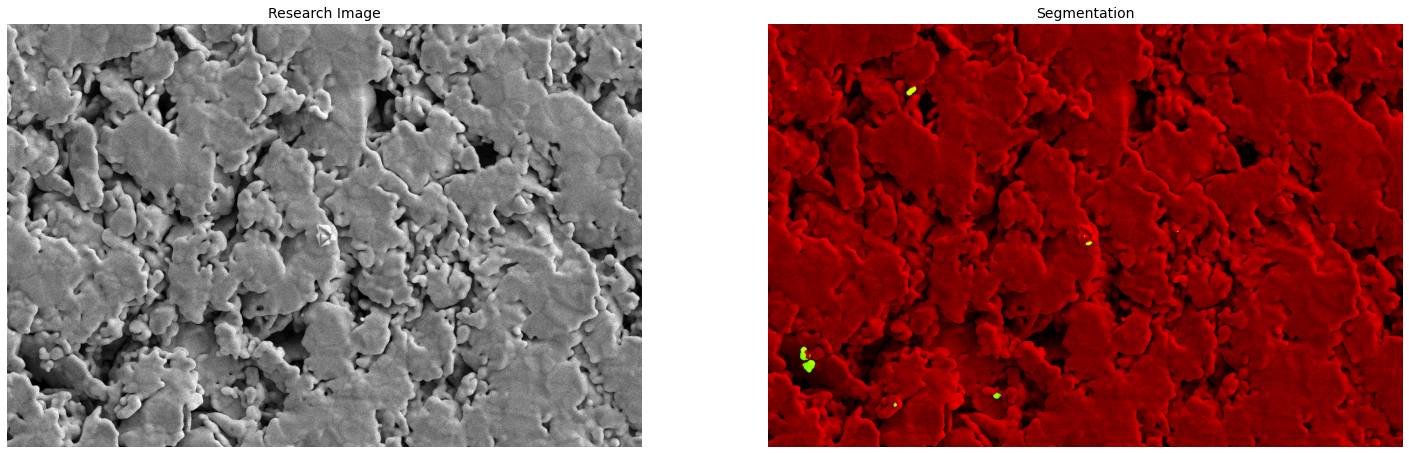

FILE name: ETD_2_026.tif
IMAGE size: (1024, 1536)
SHELL - pixels: Number = 1688  |  Density = 0.00107
CORE - pixels: Number = 0  |  Density = 0.0
window_step = 256


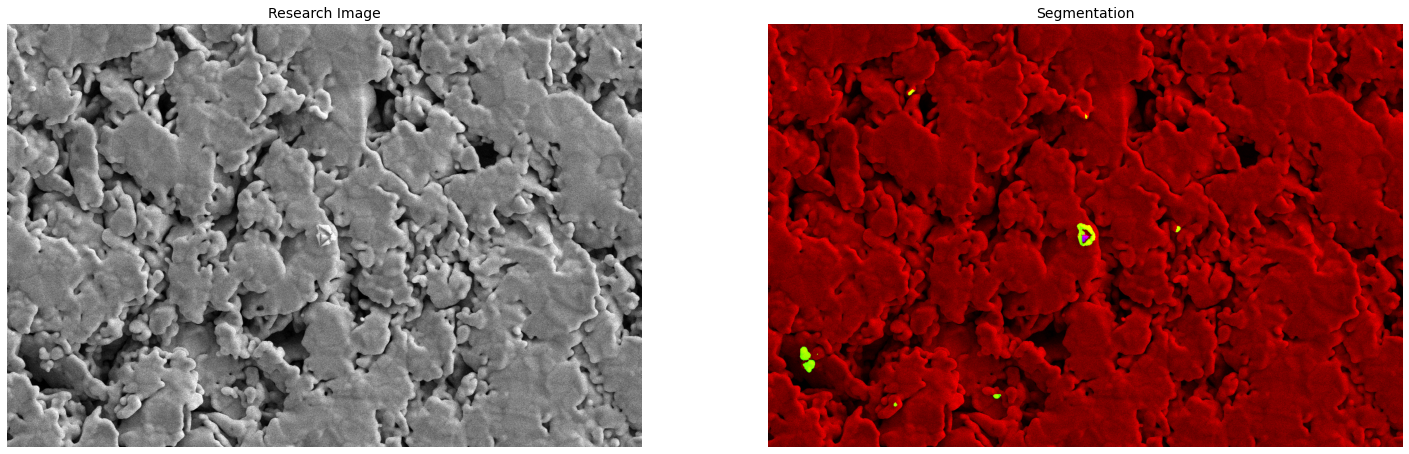

FILE name: ETD_2_026.tif
IMAGE size: (1024, 1536)
SHELL - pixels: Number = 3177  |  Density = 0.00202
CORE - pixels: Number = 177  |  Density = 0.00011
window_step = 128


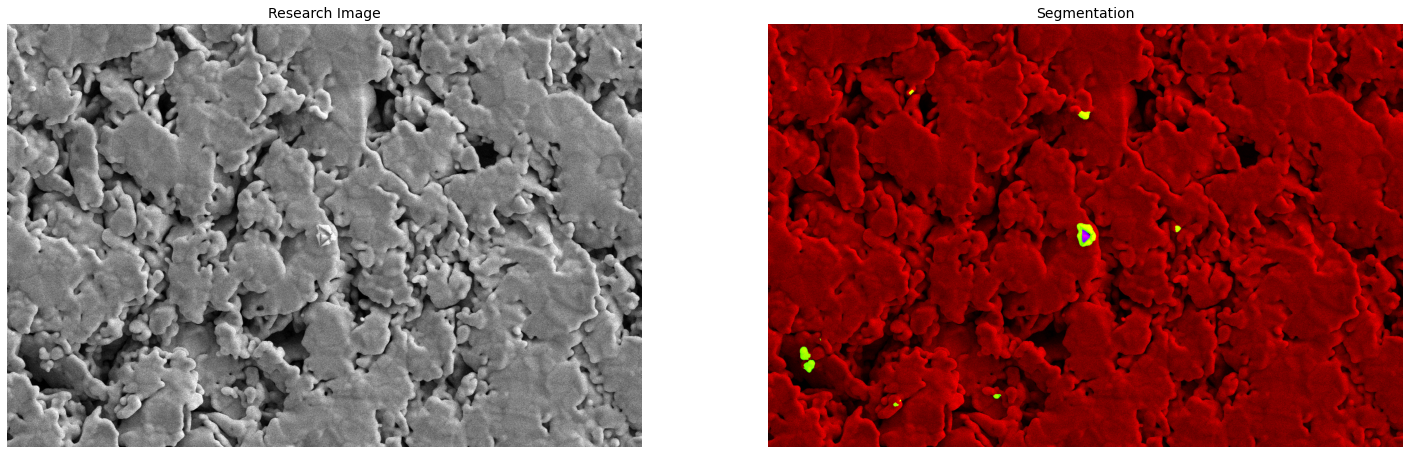

FILE name: ETD_2_026.tif
IMAGE size: (1024, 1536)
SHELL - pixels: Number = 3776  |  Density = 0.0024
CORE - pixels: Number = 402  |  Density = 0.00026
window_step = 64


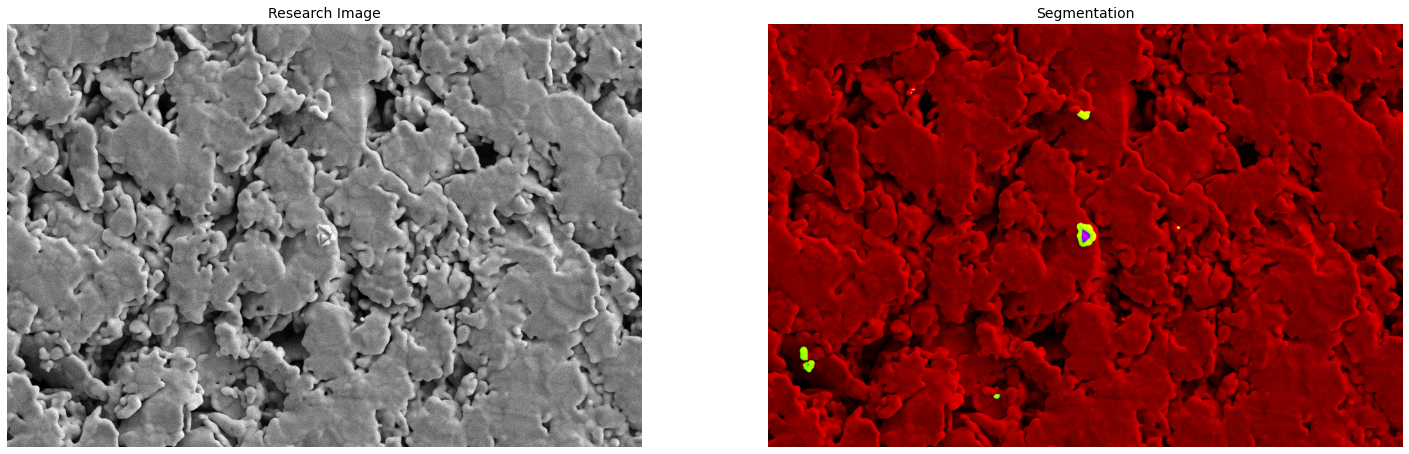

FILE name: ETD_2_026.tif
IMAGE size: (1024, 1536)
SHELL - pixels: Number = 3457  |  Density = 0.0022
CORE - pixels: Number = 422  |  Density = 0.00027
window_step = 32


In [29]:
if TEST_UNET:
    unet_256 = ResearchAnode(best_unet)
    for step in [256, 128, 64, 32]:
        unet_256.segmentation('ETD_2_026.tif', window_step=step,
                              batch_size=BATCH_UNET, verbose=0)
        unet_256.show_result()
        print('window_step =', unet_256.window_step)


## Различные изображения

### U-Net

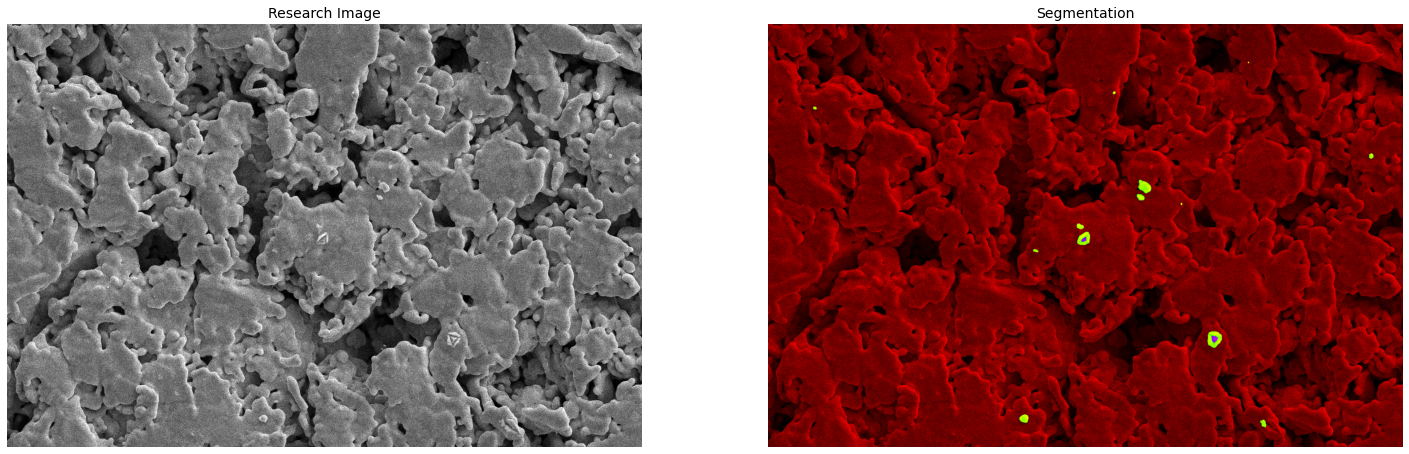

FILE name: ETD_1_002.tif
IMAGE size: (1024, 1536)
SHELL - pixels: Number = 3527  |  Density = 0.00224
CORE - pixels: Number = 265  |  Density = 0.00017
window_step = 32


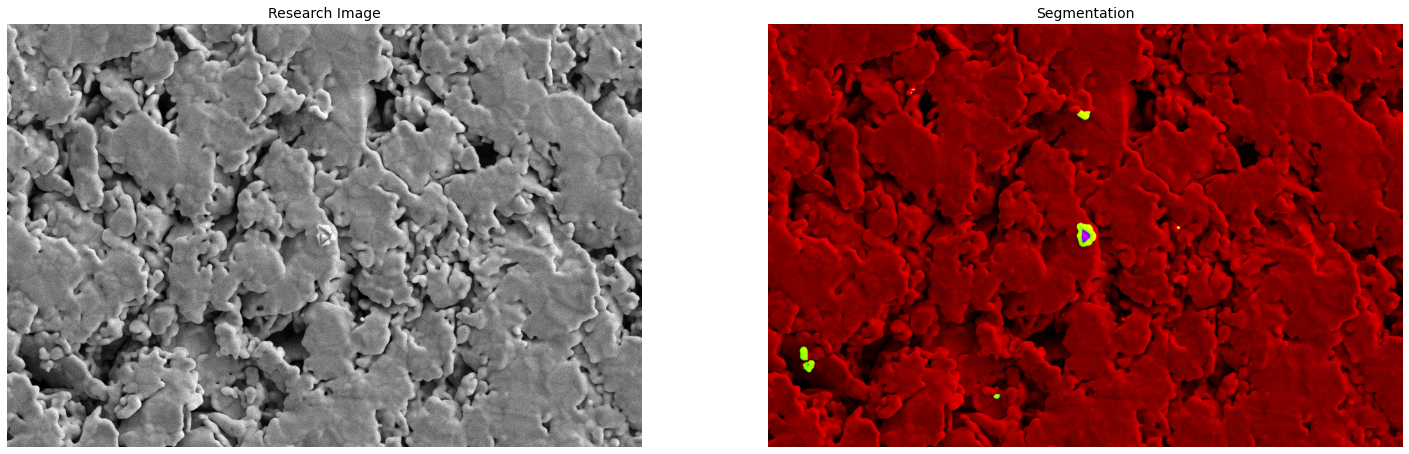

FILE name: ETD_2_026.tif
IMAGE size: (1024, 1536)
SHELL - pixels: Number = 3457  |  Density = 0.0022
CORE - pixels: Number = 422  |  Density = 0.00027
window_step = 32


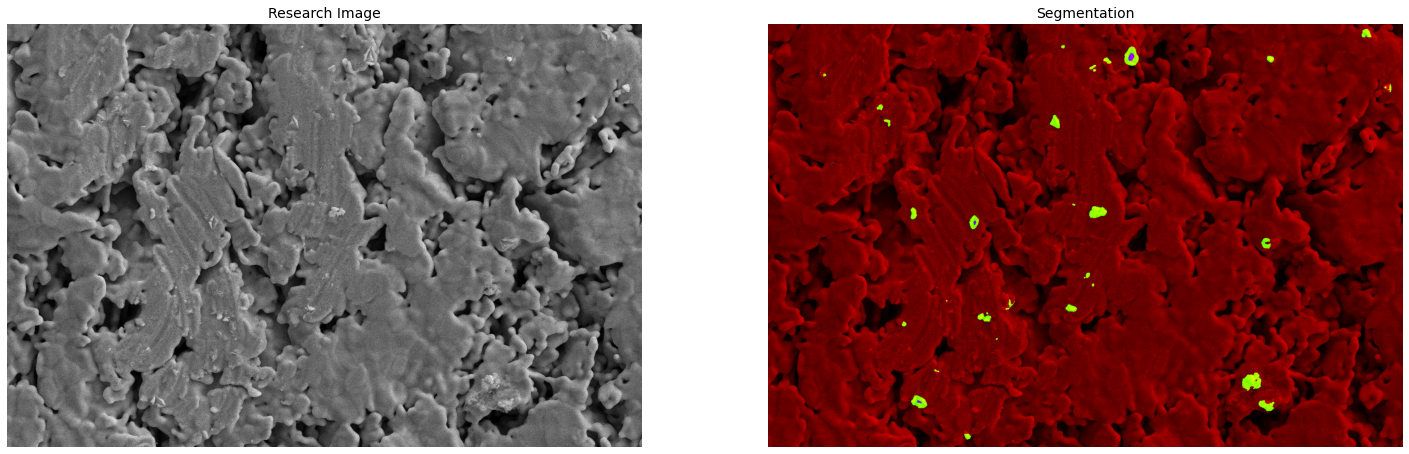

FILE name: ETD_2_082.tif
IMAGE size: (1024, 1536)
SHELL - pixels: Number = 9300  |  Density = 0.00591
CORE - pixels: Number = 303  |  Density = 0.00019
window_step = 32


In [30]:
if TEST_UNET:
    unet_256 = ResearchAnode(best_unet)
    for image in ['ETD_1_002.tif',
                  'ETD_2_026.tif',
                  'ETD_2_082.tif']:
        unet_256.segmentation(image, window_step=32,
                              batch_size=BATCH_UNET, verbose=0)
        unet_256.show_result()
        print('window_step =', unet_256.window_step)
